In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mellaniasylvie","key":"9d95b45ca7ab671e15179b127c44f507"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset

 98% 118M/121M [00:00<00:00, 219MB/s] 
100% 121M/121M [00:00<00:00, 198MB/s]


In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import zipfile
import os
import numpy as np

In [ ]:
local_zip = '/content/face-expression-recognition-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/images/images'

In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

In [ ]:
image_height = image_width = 48
batch_size = 128

In [ ]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(image_height, image_width)
  )

Found 28821 files belonging to 7 classes.


In [ ]:
class_names = data_train.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


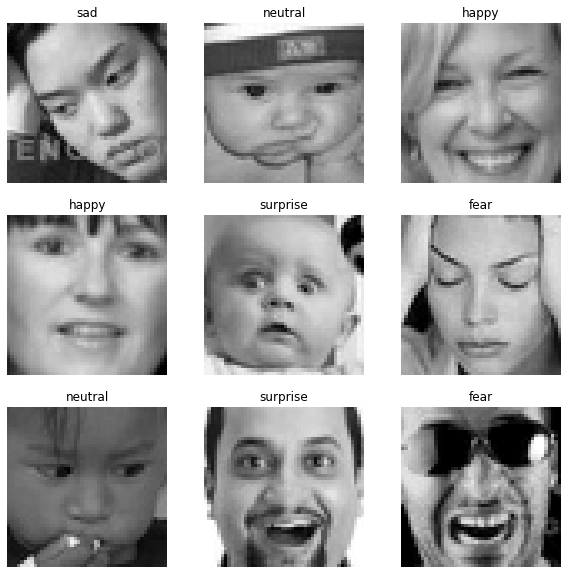

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_test = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(image_height, image_width)
  )

Found 7066 files belonging to 7 classes.


In [ ]:
class_names = data_test.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


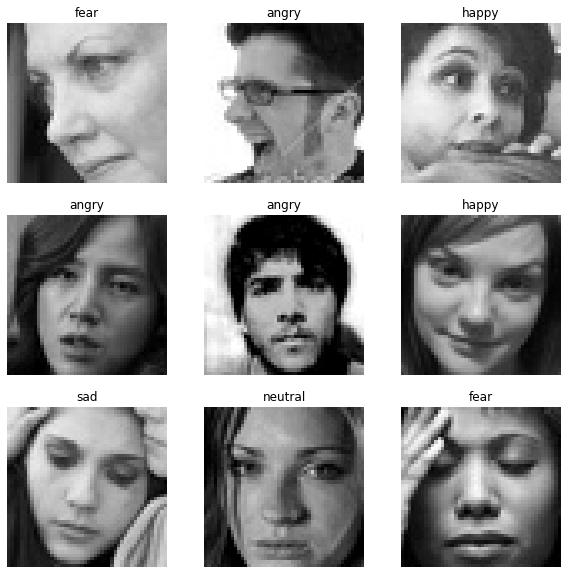

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data_test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.4,1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest'
                                   )
    
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    color_mode = 'grayscale',
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(image_height,image_width),
    color_mode = 'grayscale',
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123,
    shuffle = False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
from sklearn.utils import class_weight 
import numpy as np
from sklearn.utils import compute_class_weight

train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.031125898894494,
 1: 9.443315858453474,
 2: 1.0034817729187702,
 3: 0.5747188322565207,
 4: 0.8264322991340254,
 5: 0.8337962159347335,
 6: 1.2846445286382884}

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [ ]:
import keras

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [ ]:
%%time
history = model.fit(train_generator, 
                    epochs=20,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr],
                    shuffle = True)

Epoch 1/20
226/226 [==============================] - 36s 121ms/step - loss: 1.8175 - accuracy: 0.2445 - val_loss: 1.7848 - val_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - 27s 121ms/step - loss: 1.7370 - accuracy: 0.2885 - val_loss: 1.6275 - val_accuracy: 0.3644 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - 26s 114ms/step - loss: 1.6220 - accuracy: 0.3584 - val_loss: 1.5038 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 4/20
226/226 [==============================] - 25s 112ms/step - loss: 1.5293 - accuracy: 0.4072 - val_loss: 1.4051 - val_accuracy: 0.4549 - lr: 0.0010
Epoch 5/20
226/226 [==============================] - 25s 111ms/step - loss: 1.4573 - accuracy: 0.4377 - val_loss: 1.3147 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 6/20
226/226 [==============================] - 25s 112ms/step - loss: 1.4049 - accuracy: 0.4616 - val_loss: 1.2766 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 7/20
226/226 [==============================] 

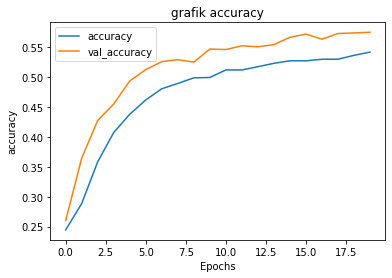

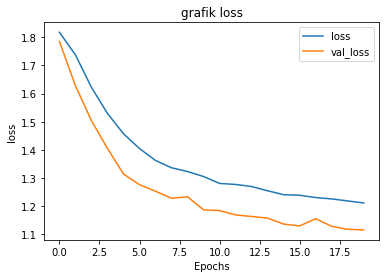

In [ ]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
grafik_plot(history, "accuracy")
grafik_plot(history, "loss")

In [ ]:
true_labels = validation_generator.classes
prob_test = model.predict(validation_generator)
predictions = prob_test.argmax(axis=1)

print('Label Sebenarnya : ', true_labels)
print('Label Prediksi : ', predictions)

test_model = model.evaluate(validation_generator, verbose=1)

56/56 [==============================] - 2s 30ms/step
Label Sebenarnya :  [0 0 0 ... 6 6 6]
Label Prediksi :  [5 5 0 ... 6 3 6]
56/56 [==============================] - 2s 33ms/step - loss: 1.1161 - accuracy: 0.5747


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('model_face.h5')

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

NameError: ignored

In [ ]:
!cp -r '/content/model_face.h5' /content/drive/MyDrive/Dataset_Skripsi/

In [ ]:
!cp -r '/content/model.json' /content/drive/MyDrive/Dataset_Skripsi/

In [ ]:
print(validation_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 48, 48, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  kelas = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  df['Kelas'] = kelas
  df = df[['Kelas', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_class = 'marah'
  elif predict_label == 1:
      predict_class = 'jijik'
  elif predict_label == 2:
      predict_class = 'takut'
  elif predict_label == 3:
      predict_class = 'senang'
  elif predict_label == 4:
      predict_class = 'b aja'
  elif predict_label == 5:
      predict_class = 'sedih'
  elif predict_label == 6:
      predict_class = 'kaget'

  return predict_class, df

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json

In [ ]:
!wget "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml" -O haarcascade_frontalface_default.xml

--2023-02-04 07:22:46--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.006s  

2023-02-04 07:22:47 (146 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
model_json_file = '/content/drive/MyDrive/Dataset_Skripsi/model.json'
model_weights_file = '/content/drive/MyDrive/Dataset_Skripsi/model_face.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
    fc = gray[y:y+h, x:x+w]
    roi = cv2.resize(fc, (48,48))
    pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
    text_idx=np.argmax(pred)
    text_list = ['Marah', 'Disgust', 'Takut', 'Bahagia', 'B aja', 'Sedih', 'WAW Kaget']
    if text_idx == 0:
      text= text_list[0]
    elif text_idx == 1:
      text= text_list[1]
    elif text_idx == 2:
      text= text_list[2]
    elif text_idx == 3:
      text= text_list[3]
    elif text_idx == 4:
      text= text_list[4]
    elif text_idx == 5:
      text= text_list[5]
    elif text_idx == 6:
      text= text_list[6]
        
    cv2.putText(img, text, (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2) 
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
1/1 [==============================] - 0s 16ms/step
Saved to photo.jpg


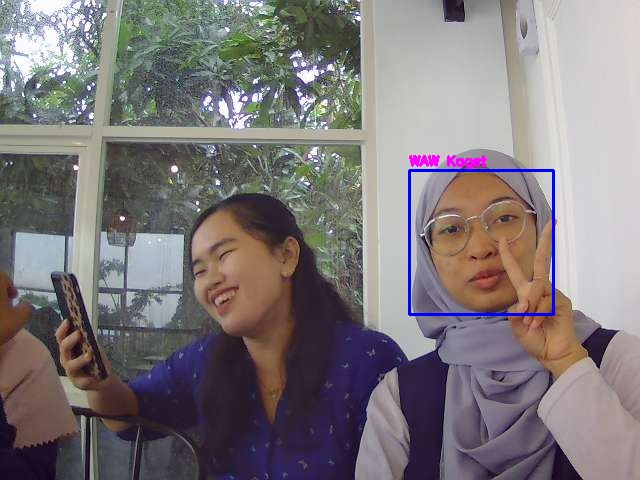

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  display(Image(filename))
except Exception as err:
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
        fc = gray[y:y+h, x:x+w]
        roi = cv2.resize(fc, (48,48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx=np.argmax(pred)
        text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        if text_idx == 0:
          text= text_list[0]
        elif text_idx == 1:
          text= text_list[1]
        elif text_idx == 2:
          text= text_list[2]
        elif text_idx == 3:
          text= text_list[3]
        elif text_idx == 4:
          text= text_list[4]
        elif text_idx == 5:
          text= text_list[5]
        elif text_idx == 6:
          text= text_list[6]
        
        cv2.putText(img, text, (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2) 
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 18ms/step
